In [13]:
import sys
import os
import shutil
import time
import importlib

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
from random import randint
from types import SimpleNamespace

In [16]:
from utils import compressor
from utils import decompressor
from utils import image_utils
from utils import network_utils
from utils import compression_utils 
from utils import glob 
from utils import performance_utils
from utils import custom_lzma

In [17]:
# In caso di modifiche ai sorgenti 
importlib.reload(image_utils)
importlib.reload(network_utils)
importlib.reload(compression_utils)
importlib.reload(glob)

<module 'utils.glob' from 'C:\\Users\\thefo\\CompressioneDati\\utils\\glob.py'>

In [18]:
autoencoder = tf.keras.models.load_model('modello.h5')

In [19]:
encoder, decoder = network_utils.get_trained_encoder_decoder(autoencoder, n_layers=6)

### 1) Compression and decompression testing and time performances

In [20]:
error_correction_desidered_quality = 1 # 1 = Lowest quality, 100 = highest_quality (almost lossless compression)
path = "dataset/valid/6.png"

In [21]:
#Compressor and decompressor time performances.
compressed_code = compressor.compress(path, encoder, decoder, error_correction_desidered_quality)
decompressed_image = decompressor.decompress(compressed_code, decoder)

Compressor STARTS
Image loaded. Elapsed: 0.22214894100000038
Image padded. Elapsed: 0.19921380200000272
Image separated into blocks. Elapsed: 0.0005233090000018592
Alpha channel LZMA-compressed. Elapsed: 2.6419273610000005
Image blocks compressed through network. Elapsed: 0.7344898909999955
Blocks recompressed through LZMA. Elapsed: 13.888327939999996
Image decompressed. Elapsed: 0.9642113960000103
Proper treshold computed. Elapsed: 0.04332775500000707
Treshold is 0.3096336519718161
Relevant errors computed. Elapsed: 0.9866078040000019
Relevant errors LZMA compressed. Elapsed: 0.869706762000007
Compressor ENDS. Total compressor computation time is 20.55497575700001

Decompressor STARTS
Alpha channel LZMA decompressed. Elapsed: 0.1135519649999992
Blocks LZMA decompressed. Elapsed: 2.7759675570000013
Blocks decompressed through decoder network. Elapsed: 0.8280630560000048
Network decompressed image saved in predicted/network_decompression.png. Elapsed: 2.831891748000004
Relevant errors d

#### 2) Compression ratio 

In [10]:
#Compression ratio evaluation
rgb_image, alpha_channel = image_utils.load_image(path)
performance_utils.evaluate_compression_ratio(rgb_image, alpha_channel, compressed_code)

size_rgb_image 27613440 shape rgb image (1128, 2040, 3)
type rgb_image <class 'numpy.float32'>

size_alpha_channel 9204480
type alpha_channel <class 'numpy.float32'>

size_compressed_blocks_lz 9822090
type compressed_blocks_lz <class 'bytes'>

size_important_errors 551837
type important_errors_lz <class 'bytes'>

size_alpha_channel_lz 1417
type alpha_channel_lz <class 'bytes'>

compression_ratio = original_size/compressed_size 
original_size = size_alpha_channel + size_rgb_image 
compressed_size = size_compressed_blocks_lz + size_important_errors_lz + size_alpha_channel_lz 


3.5485975212002607

#### 3) Autoencoder block compression/decompression error (mean and std)

In [23]:
#Autoencoder's compression/decompression error evaluation (mean and standard deviation)
(compressed_blocks_lz, compressed_blocks_shape, 
important_errors_lz, imp_errors_shape,
padding_info, width_immagine_originale,
height_immagine_originale, alpha_channel_lz) = compressed_code
    
    
compressed_blocks = custom_lzma.decompression(compressed_blocks_lz)
compressed_blocks = compressed_blocks.reshape(compressed_blocks_shape)

error_informations = performance_utils.autoencoder_error_evaluation(rgb_image, compressed_blocks,
                                                                    decoder, width_immagine_originale, 
                                                                    height_immagine_originale, padding_info,
                                                                    p=True)
error_informations = error_informations [2:6]

print ("mean error " + str(error_informations[0]))
print ("error std " + str(error_informations[1]))
print ("mean absolute error " + str(error_informations[2]))
print ("asolute error std " + str(error_informations[3]))

mean error 0.005701641
error std 0.08639764
mean absolute error 0.057652388
asolute error std 0.06460084


#### 4) Autoencoder with error correction: PSNR

In [24]:
decoded_image = err_corrected_image = image_utils.load_image("predicted/decompression_error_corrected.png")[0]
decoded_image_rgb = decoded_image[:,:, :3]
performance_utils.get_psnr(rgb_image, decoded_image)

17.55225058765577

### 5) Autoencoder block compression/decompression error (mean and std) on validation set

In [ ]:
validation_set_error_infos = performance_utils.validation_set_autoencoder_error_evaluation(encoder, decoder)
for i in range (len(validation_set_error_infos)):
    curr = validation_set_error_infos[i]
    print ("Image dataset/train/" + str(i) + ".png")
    print ("mean error " + str(curr[0]))
    print ("error std " + str(curr[1]))
    print ("mean absolute error " + str(curr[2]))
    print ("asolute error std " + str(curr[3]) + "\n") 

### 6) Lena, Parrots, Madrill: PSNR and compression ratio values with all possible error correction quality values [1 - 100]

In [ ]:
#PSNR amd compression_ratio evaluation with all possible error correction quality values 
image_paths = ["lena.png", "parrots.png", "mandrill.png"]
psnrs, compression_ratios = performance_utils.estimate_psnr_and_compr_ratio(image_paths, encoder, decoder)

### 6.b) Plot Compression Ratio compared to error correction quality

# 

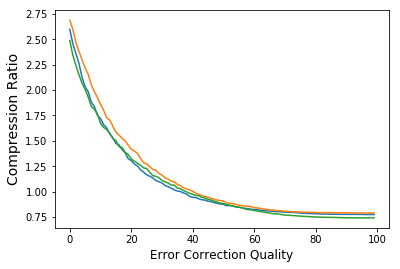

In [26]:
plt.xlabel('Error Correction Quality', fontsize=12)
plt.ylabel('Compression Ratio', fontsize=14)
plt.plot(np.asarray(compression_ratios[0])) # Blue curve for Lena
plt.plot(np.asarray(compression_ratios[1])) # Orange curve for Parrots
plt.plot(np.asarray(compression_ratios[2])) # Green curve for Mandrill

#### 6.c) Plot PSNR compared to error correction quality

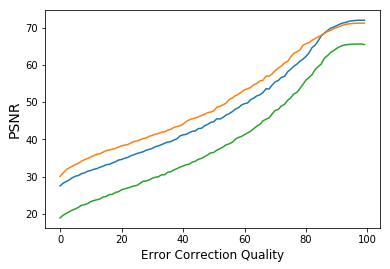

In [12]:
plt.xlabel('Error Correction Quality', fontsize=12)
plt.ylabel('PSNR', fontsize=14)
plt.plot(np.asarray(psnrs[0])) # Blue curve for Lena
plt.plot(np.asarray(psnrs[1])) # Orange curve for Parrots
plt.plot(np.asarray(psnrs[2])) # Green curve for Mandrill

#### 6.d) (Lena, Parrots, Mandrill) Plot PSNR compared to Compression ratio with same error correction quality value

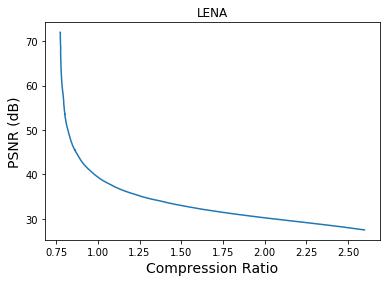

In [48]:
lena_comp_ratios = compression_ratios[0]
lena_psnrs = psnrs[0]
plt.title("LENA")
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=14)
plt.plot(lena_comp_ratios, lena_psnrs)

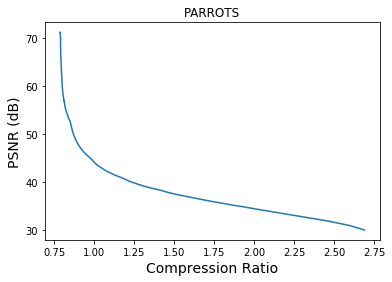

In [49]:
parrots_comp_ratios = compression_ratios[1]
parrots_psnrs = psnrs[1]
plt.title("PARROTS")
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=14)
plt.plot(parrots_comp_ratios, parrots_psnrs)

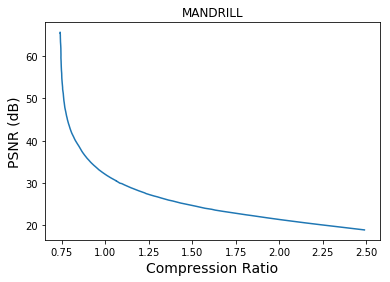

In [50]:
mandrill_comp_ratios = compression_ratios[2]
mandrill_psnrs = psnrs[2]
plt.title("MANDRILL")
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=14)
plt.plot(mandrill_comp_ratios, mandrill_psnrs)

### Load compression ratios and psnrs vectors

In [11]:
psnrs = np.load("psnrs.npy")
compression_ratios = np.load("compression_ratios.npy")

### Get and train a new autoencoder instance

In [ ]:
conv_network = network_utils.get_autoencoder()
# Training takes 8 hours on NVIDIA GeForce 150MX
conv_network = network_utils.fit_network(conv_network)
encoder = network_utils.get_encoder()
encoder.set_weights(conv_network.get_weights()[0:6] )
decoder = network_utils.get_decoder()
decoder.set_weights(conv_network.get_weights()[6:] )